In [119]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sps
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor


from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from sklearn.tree import plot_tree, export_text

from pprint import pprint

## Data

In [47]:
uavsar_snodas = pd.read_csv('/home/naheemadebisi/PhD/snow-analytics/Radar-Backscatter/uavsar_snodas/all_uavsar_snodas.csv')
uavsar_snodas.describe()

,Unnamed: 0,HH_mean,HV_mean,VH_mean,VV_mean,SWE_m,snow_melt_base_m,sp_avg_temp_SNODAS_k,blow_snow_sublim_m,snow_depth_m,liquid_precip_kgm2,sp_sublim_m,snow_precip_kgm2
count,52542.000000,52542.000000,52542.000000,52542.000000,52542.000000,52542.000000,52542.000000,52542.000000,52542.000000,52542.000000,52542.000000,52542.000000,52542.000000
mean,8928.182616,0.344258,0.152360,0.148579,0.288310,0.297095,0.000362,270.074017,-0.000005,0.893053,0.138843,-0.000400,0.853479
std,3816.920185,0.165942,0.067023,0.066408,0.154250,0.158154,0.001475,2.148168,0.000113,0.433510,0.604528,0.000263,2.217810
min,1144.000000,0.000076,0.000046,0.000035,0.000088,0.000000,0.000000,262.000000,-0.006930,0.000000,0.000000,-0.001790,0.000000
25%,5774.000000,0.231826,0.101408,0.098273,0.185984,0.176000,0.000000,269.000000,0.000000,0.560000,0.000000,-0.000520,0.000000
50%,8876.500000,0.314398,0.142891,0.137899,0.258426,0.297000,0.000000,270.000000,0.000000,0.906000,0.000000,-0.000330,0.000000
75%,11990.000000,0.421055,0.192910,0.188069,0.346088,0.411000,0.000000,272.000000,0.000000,1.226000,0.000000,-0.000230,0.100000
max,18088.000000,2.013035,0.573557,0.546923,1.830261,0.774000,0.021770,273.000000,0.000000,2.061000,8.500000,0.000390,16.000000


#Boxplot for the amplitude at different polarization

## Setup

In [30]:
#input and output data
input_col = ['SWE_m', 'sp_avg_temp_SNODAS_k',  'snow_depth_m', 'snow_melt_base_m', 'blow_snow_sublim_m', 'liquid_precip_kgm2', 'sp_sublim_m', 'snow_precip_kgm2']
output_col = 'HH_mean'

inputs = uavsar_snodas[input_col]
target = uavsar_snodas[output_col]

In [48]:
#transform numerical columns
scaler = StandardScaler()
scaler.fit(inputs)
scaler.mean_

array([ 2.97095314e-01,  2.70074017e+02,  8.93052796e-01,  3.61777055e-04,
       -4.77560808e-06,  1.38843211e-01, -4.00456206e-04,  8.53479122e-01])

In [32]:
inputs_scaled = scaler.transform(inputs)
inputs_scaled

array([[-1.15771249, -0.96549074, -0.94359187, ..., -0.22967421,
         0.64839917,  0.47187571],
       [-1.26520355, -0.96549074, -1.05893054, ..., -0.22967421,
         0.34408679,  0.42678575],
       [-1.29049557, -1.43100801, -1.0866118 , ..., -0.22967421,
         0.22996965,  0.38169585],
       ...,
       [-1.18300451,  1.36209565, -1.26884685, ..., -0.22967421,
        -1.21551414, -0.38483329],
       [-1.48018571,  1.36209565, -1.52028508, ..., -0.22967421,
        -0.72100653, -0.38483329],
       [-1.53076975,  1.36209565, -1.66099823, ..., -0.22967421,
        -0.11238178, -0.38483329]])

## Fit  a Linear Regression model using SKlearn

In [49]:
#train-test split
inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs_scaled, target, test_size=0.3)

In [50]:
#fit a model to the data
lnr_model = LinearRegression().fit(inputs_train, targets_train)

#predict
predictions_test = lnr_model.predict(inputs_test)

#compute loss
mse_loss = mse(targets_test, predictions_test)
rsquare = r2_score(targets_test, predictions_test) 
print(f'Test mse: {mse_loss}')
print(f'Test r_square: {rsquare}')

Test mse: 0.024341545366339718
Test r_square: 0.08859787786741458


In [51]:
weights_df = pd.DataFrame({
    'feature': input_col,
    'weight': lnr_model.coef_
})
weights_df.sort_values('weight', ascending=False)

,feature,weight
2,snow_depth_m,0.071266
1,sp_avg_temp_SNODAS_k,0.048342
5,liquid_precip_kgm2,0.010352
6,sp_sublim_m,0.005702
4,blow_snow_sublim_m,-0.000305
3,snow_melt_base_m,-0.002693
7,snow_precip_kgm2,-0.011614
0,SWE_m,-0.085439


In [94]:
def build_model(model, input_train = inputs_train, target_train = targets_train, input_test = inputs_test, target_test = targets_test):
    #fit a model on training data
    model_fit = model.fit(input_train, target_train)
    
    #predict train
    predictions_train = model_fit.predict(input_train)
    #predict test
    predictions_test = model_fit.predict(input_test)

    #compute loss train
    mse_loss = mse(target_train, predictions_train)
    rsquare = r2_score(target_train, predictions_train) 
    print(f'Train mse: {mse_loss}')
    print(f'Train r_square: {rsquare}')

    #compute loss test
    mse_loss = mse(target_test, predictions_test)
    rsquare = r2_score(target_test, predictions_test) 
    print(f'Test mse: {mse_loss}')
    print(f'Test r_square: {rsquare}')

    return model_fit

def feature_importance(fitted_model):
    #feature importance
    importance_df = pd.DataFrame({
    'feature': uavsar_snodas[input_col].columns,
    'importance': fitted_model.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.title('Feature Importance')
    sns.barplot(data=importance_df.head(10), x='importance', y='feature');



## Decisison Tree with Sklearn

In [95]:
DT = build_model(DecisionTreeRegressor())

Train mse: 9.846724902045683e-06
Train r_square: 0.9996469630948807
Test mse: 0.042947383509825576
Test r_square: -0.60804648520896


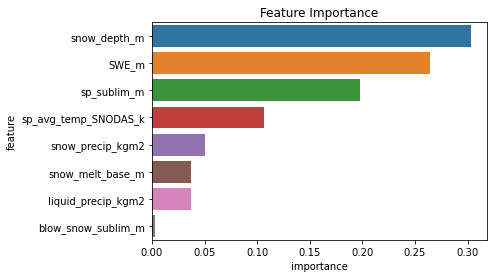

In [98]:
feature_importance(DT)

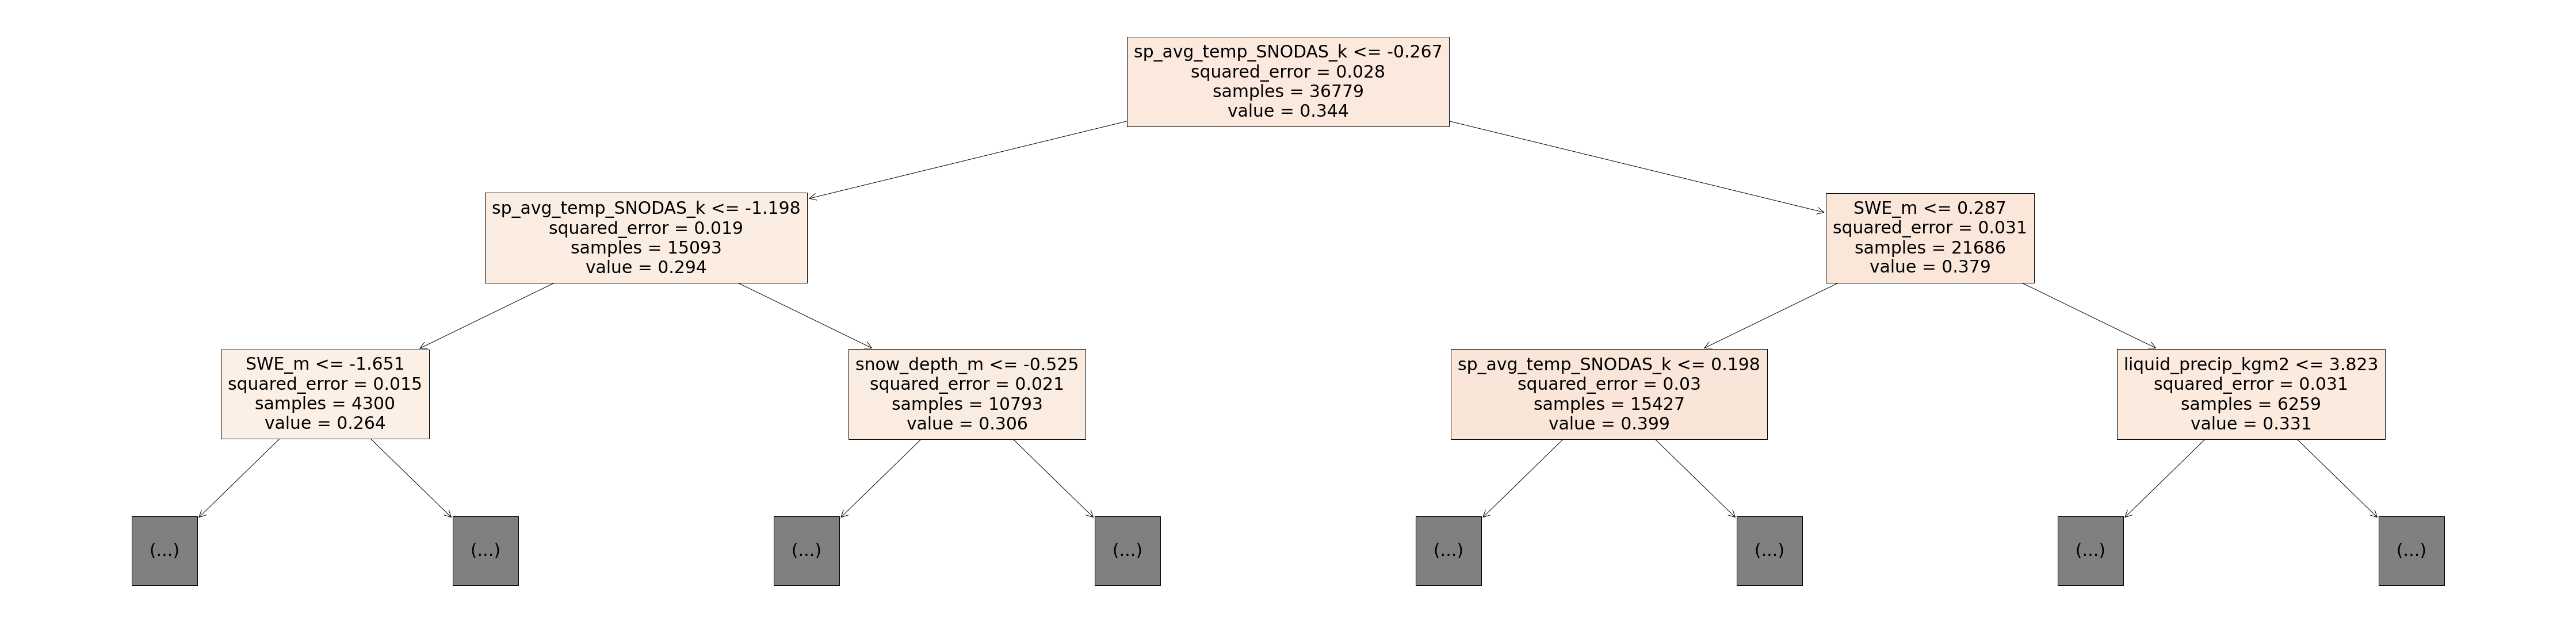

In [96]:
plt.figure(figsize=(80,20))
plot_tree(DT, feature_names= uavsar_snodas[input_col].columns, max_depth=2, filled=True);

In [84]:
baseline_pred = pd.Series(targets_test.mean(), index = targets_test.index)

In [86]:

mse_loss = mse(targets_test, baseline_pred)
rsquare = r2_score(targets_test, baseline_pred) 
print(f'Test mse: {mse_loss}')
print(f'Test r_square: {rsquare}')

Test mse: 0.026707799746376555
Test r_square: 0.0


## SKlearn with Random Forest

In [97]:
RF = build_model(RandomForestRegressor())

Train mse: 0.003291554790725239
Train r_square: 0.8819871248655539
Test mse: 0.02230161900985641
Test r_square: 0.16497730170071134


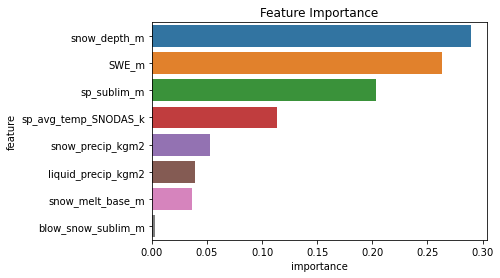

In [99]:
feature_importance(RF)

In [101]:
RF.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

## Tuning Random Forest 

In [122]:
# Number of trees in random forest-> 10 values between 0 and 2000
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 2000, num = 10)]

# Maximum number of depth and leaf nodes in tree
max_depth = [int(x) for x in np.linspace(1, 110, num = 10)]
max_depth.append(None)

max_leaf_nodes = [int(x) for x in np.linspace(1, 200, num = 10)]
max_leaf_nodes.append(None)

# Number of features to consider at every split
max_features = ['sqrt', 'log2', None]

# Minimum number of samples split and sample leaf required to split a node
min_samples_split = [2, 5, 10,15]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8, 10]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
                'max_depth': max_depth,
                'max_leaf_nodes' : max_leaf_nodes,
               'max_features': max_features,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [1, 13, 25, 37, 49, 61, 73, 85, 97, 110, None],
 'max_features': ['sqrt', 'log2', None],
 'max_leaf_nodes': [1, 23, 45, 67, 89, 111, 133, 155, 177, 200, None],
 'min_samples_leaf': [1, 2, 4, 8, 10],
 'min_samples_split': [2, 5, 10, 15],
 'n_estimators': [10, 231, 452, 673, 894, 1115, 1336, 1557, 1778, 2000]}


In [123]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
RF2 = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = RF2, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(inputs_train, targets_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=False, max_depth=49, max_features=None, max_leaf_nodes=23, min_samples_leaf=4, min_samples_split=5, n_estimators=894; total time=  55.2s
[CV] END bootstrap=False, max_depth=49, max_features=None, max_leaf_nodes=23, min_samples_leaf=4, min_samples_split=5, n_estimators=894; total time=  55.3s
[CV] END bootstrap=False, max_depth=49, max_features=None, max_leaf_nodes=23, min_samples_leaf=4, min_samples_split=5, n_estimators=894; total time=  56.4s
[CV] END bootstrap=False, max_depth=85, max_features=sqrt, max_leaf_nodes=111, min_samples_leaf=2, min_samples_split=15, n_estimators=2000; total time=  59.1s
[CV] END bootstrap=False, max_depth=85, max_features=sqrt, max_leaf_nodes=111, min_samples_leaf=2, min_samples_split=15, n_estimators=2000; total time=  59.2s
[CV] END bootstrap=False, max_depth=85, max_features=sqrt, max_leaf_nodes=111, min_samples_leaf=2, min_samples_split=15, n_estimators=2000; total time=

/home/naheemadebisi/miniconda3/envs/earth-analytics-python/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=97, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=4, min_samples_split=2, n_estimators=1336; total time=  51.1s
[CV] END bootstrap=True, max_depth=97, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=4, min_samples_split=2, n_estimators=1336; total time=  51.7s
[CV] END bootstrap=False, max_depth=25, max_features=sqrt, max_leaf_nodes=177, min_samples_leaf=4, min_samples_split=5, n_estimators=1778; total time=  57.5s
[CV] END bootstrap=False, max_depth=25, max_features=sqrt, max_leaf_nodes=177, min_samples_leaf=4, min_samples_split=5, n_estimators=1778; total time= 1.0min
[CV] END bootstrap=False, max_depth=25, max_features=sqrt, max_leaf_nodes=177, min_samples_leaf=4, min_samples_split=5, n_estimators=1778; total time= 1.0min
[CV] END bootstrap=False, max_depth=73, max_features=sqrt, max_leaf_nodes=45, min_samples_leaf=8, min_samples_split=2, n_estimators=1557; total time=  39.1s
[CV] END bootstrap=False, max_depth=73, max_features=

/home/naheemadebisi/miniconda3/envs/earth-analytics-python/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/home/naheemadebisi/miniconda3/envs/earth-analytics-python/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/naheemadebisi/miniconda3/envs/earth-analytics-python/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 476, in fit
    trees = Parallel(
  File "/home/naheemadebisi/miniconda3/envs/earth-analytic

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [1, 13, 25, 37, 49, 61, 73,
                                                      85, 97, 110, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'max_leaf_nodes': [1, 23, 45, 67, 89,
                                                           111, 133, 155, 177,
                                                           200, None],
                                        'min_samples_leaf': [1, 2, 4, 8, 10],
                                        'min_samples_split': [2, 5, 10, 15],
                                        'n_estimators': [10, 231, 452, 673, 894,
                                                         1115, 1336, 1557, 1778,
                                                         2000]},
                   random_state=42, verbose=2)

In [127]:
rf_random.best_params_

{'n_estimators': 1336,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_leaf_nodes': None,
 'max_features': 'sqrt',
 'max_depth': 97,
 'bootstrap': True}

In [130]:
#predict train
predictions_train = rf_random.best_estimator_.predict(inputs_train)
#predict test
predictions_test = rf_random.best_estimator_.predict(inputs_test)

#compute loss train
mse_loss = mse(targets_train, predictions_train)
rsquare = r2_score(targets_train, predictions_train) 
print(f'Train mse: {mse_loss}')
print(f'Train r_square: {rsquare}')

#compute loss test
mse_loss = mse(targets_test, predictions_test)
rsquare = r2_score(targets_test, predictions_test) 
print(f'Test mse: {mse_loss}')
print(f'Test r_square: {rsquare}')

Train mse: 0.01548210545110153
Train r_square: 0.4449164927871051
Test mse: 0.02095220562327275
Test r_square: 0.21550236926142396


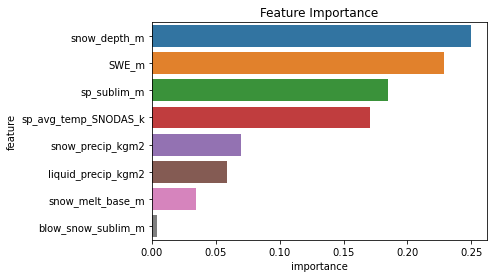

In [131]:
feature_importance(rf_random.best_estimator_)